Analytic calculation of reconstructed kappa noise and delensing efficiency

In [21]:
import numpy as np, basic, prjlib, quad_func, plottools as pl, tools_lens, tools_delens
from matplotlib.pyplot import *

In [22]:
p = prjlib.analysis_init(t='la',freq='coadd',lTmin=500,lTmax=3000)
pco = prjlib.analysis_init(t='co',freq='coadd')
ep = 1e-60

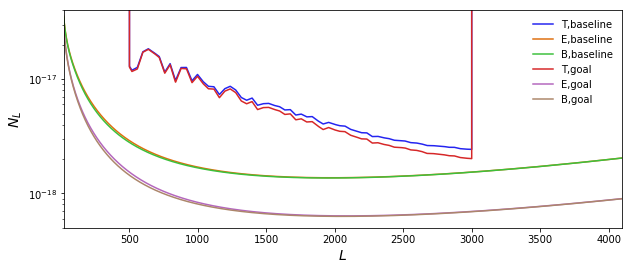

In [23]:
pl.plot_1dstyle(fsize=[10,4],xmin=20,xmax=4096,ylog=True,ymin=5e-19,ymax=4e-17,ylab='$N_L$')
Nl = {}
l = np.linspace(0,p.lmax,p.lmax+1)
for ntype in ['baseline','goal']:
    Nl[ntype] = prjlib.nlofficial(dimless=True,ntype=ntype,lTmin=p.lTmin,lTmax=p.lTmax,deproj=0,lmax=p.lmax,cols=(3,4,5,6))
    plot(l,Nl[ntype][0],label='T,'+ntype)
    plot(l,Nl[ntype][1],label='E,'+ntype)
    plot(l,Nl[ntype][2],label='B,'+ntype)
legend()

In [24]:
# phi normalization
al = {}
d = prjlib.data_directory()
for ntype in ['baseline','goal']:
    print(ntype)
    if ntype == 'sim': 
        ocl = prjlib.loadocl(p.fcmb.scl['o'],lTmin=100,lTmax=3000)
    else:
        ocl = np.zeros((4,p.lmax+1))
        ocl[0:3,:] = p.lcl[0:3,:] + Nl[ntype][0:3]
    qobj = tools_lens.init_qobj(p.ids,p.stag+'_iso_ana',lcl=p.lcl,ocl=ocl,ifl=ocl,rlmin=300,rlmax=4096,olmax=2048)
    als, __ = quad_func.quad.al(qobj,output=False,overwrite=True)
    als['PO'] = 1./(1./(als['EE']+ep)+1./(als['EB']+ep))
    als['TP'] = 1./(1./(als['TT']+ep)+1./(als['TE']+ep)+1./(als['EE']+ep)+1./(als['EB']+ep))
    al[ntype] = als

baseline
goal


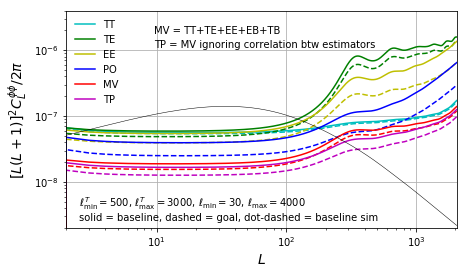

In [25]:
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=2048,xlog=True,ylog=True,ymin=2e-9,ymax=4e-6,grid=True,ylab=r'$[L(L+1)]^2C^{\phi\phi}_L/2\pi$')
for q, c in [('TT','c'),('TE','g'),('EE','y'),('PO','b'),('MV','r'),('TP','m')]:
    #for ls, ntype in [('-','baseline'),('--','goal'),('-.','sim')]:
    for ls, ntype in [('-','baseline'),('--','goal')]:
        if ntype == 'baseline': 
            plot(qobj.l,al[ntype][q]*2./np.pi,label=q,color=c,ls=ls)
        else:
            plot(qobj.l,al[ntype][q]*2./np.pi,color=c,ls=ls)
plot(qobj.l,p.kk[:qobj.olmax+1]*2./np.pi,'k-',lw=.5)
figtext(.3,.75,r'TP = MV ignoring correlation btw estimators')
figtext(.3,.80,r'MV = TT+TE+EE+EB+TB')
figtext(.15,.15,r'solid = baseline, dashed = goal, dot-dashed = baseline sim')
figtext(.15,.20,r'$\ell^T_{\rm min}='+str(p.lTmin)+r'$, $\ell^T_{\rm max}='+str(p.lTmax)+r'$, $\ell_{\rm min}=30$, $\ell_{\rm max}=4000$')
legend()
#savefig('so_noise_kappa.png')

In [50]:
# compute residual BB and template B-mode spectra
def func(dElmin,dlmin=2,dlmax=2048):
    R = {}
    WE = np.ones(dlmax+1)
    WE[:dElmin] = 0.
    #for ls, ntype in [('-','baseline'),('--','goal'),('-.','sim')]:
    for ntype in ['baseline','goal']:
        wlk = tools_delens.diag_wiener(qobj.f,p.kk,dlmin,dlmax,Al=al[ntype],klist=['TT','TE','EE','MV'])
        #for q, c in [('TT','c'),('TE','g'),('EE','y'),('PO','b'),('MV','r'),('TP','m')]:
        #for q, c in [('TT','c'),('TE','g'),('EE','y'),('MV','r')]:
        for q in ['MV']:
            BB = basic.delens.lintemplate(p.lmax,dlmin,dlmax,p.uEE[:dlmax+1],p.pp[:dlmax+1],WE,wlk[q])
            bb = basic.delens.lensingbb(p.lmax,2,2048,p.uEE[:2049],p.pp[:2049])
            R[ntype] = BB/(bb+ep)
    return R
#savefig('so_efficiency.png')

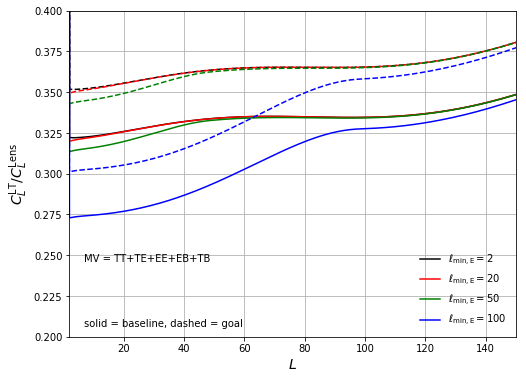

In [54]:
R = {} 
pl.plot_1dstyle(fsize=[8,6],xmin=2,xmax=150,ymin=.2,ymax=.4,grid=True,ylab=r'$C_L^{\rm LT}/C_L^{\rm Lens}$')
for c, dElmin in [('k',2),('r',20),('g',50),('b',100)]:
    R = func(dElmin)
    for ls, ntype in [('-','baseline'),('--','goal')]:
        if ntype == 'baseline': 
            plot(R[ntype],color=c,label=r'$\ell_{\rm min,E}=$'+str(dElmin),ls=ls)
        else:
            plot(R[ntype],color=c,ls=ls)
figtext(.15,.30,r'MV = TT+TE+EE+EB+TB')
figtext(.15,.15,r'solid = baseline, dashed = goal')
#figtext(.15,.20,r'$L_{\rm min}='+str(dElmin)+r'$, $L_{\rm max}=2048$')
legend(loc=4)